In [1]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

Use GPU: False


In [23]:
# Config Section

cfg_data_folder = "datasets/cifar10"
# cfg_log_folder = "logs"
# cfg_log_version = "cifar10"

cfg_max_epochs = 50
cfg_hidden_dim = 42

cfg_cifar10_labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

cfg_num_workers = 5


In [24]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [25]:
x_train.shape

torch.Size([40000, 32, 32, 3])

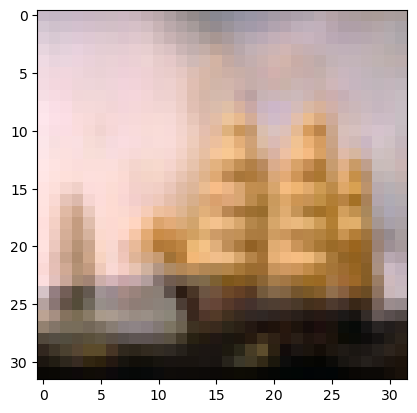

Label: Ship (idx: 8)


In [26]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()
print(f"Label: {cfg_cifar10_labels.get(int(y_train[0]))} (idx: {y_train[0]})")

In [27]:
# Define model
class WideNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.flatten_layer = torch.nn.Flatten()
        self.hidden_layer = torch.nn.Linear(input_size.numel(),
                                            hidden_size)
        self.hidden_activation = torch.nn.Tanh()
        self.output_layer = torch.nn.Linear(hidden_size,
                                            output_size)
    
    def forward(self, x):
        y = x
        y = self.flatten_layer(y)
        y = self.hidden_activation(self.hidden_layer(y))
        y = self.output_layer(y)
        return y
        
    def predict(self, x):
        y = x
        y = self.forward(y)
        y = torch.softmax(y, -1)
        return y

In [28]:
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [29]:
print(f"Hidden Dims: {cfg_hidden_dim}")

model = PLModel(WideNetwork(x_train.shape[1:],
                            len(y_train.unique()),
                            cfg_hidden_dim))

summary(model, input_size=(1,)+x_train.shape[1:])

Hidden Dims: 42


Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 10]                   --
├─WideNetwork: 1-1                       --                        --
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Linear: 2-2                       [1, 42]                   129,066
│    └─Tanh: 2-3                         [1, 42]                   --
│    └─Linear: 2-4                       [1, 10]                   430
Total params: 129,496
Trainable params: 129,496
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.13
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.52
Estimated Total Size (MB): 0.53

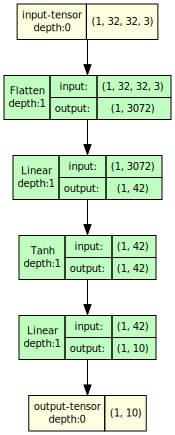

In [30]:
# Depth Setting
model_graph = draw_graph(model, input_size=(1,)+x_train.shape[1:], device=device, depth=3)

model_graph.visual_graph

In [31]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.09412207, 0.07796163, 0.0969125 , 0.10960793, 0.10962307,
        0.10876372, 0.10923282, 0.11967789, 0.07562174, 0.09847662],
       [0.11000157, 0.07413591, 0.08574995, 0.12026003, 0.12125706,
        0.09995826, 0.103672  , 0.09632788, 0.08415367, 0.10448372],
       [0.07658895, 0.10188223, 0.11371328, 0.09779225, 0.09130995,
        0.09927066, 0.09991593, 0.1039073 , 0.08868846, 0.12693094],
       [0.11412645, 0.09605928, 0.10165811, 0.09073555, 0.12949824,
        0.08694629, 0.0854293 , 0.09342496, 0.07268477, 0.12943703],
       [0.08756071, 0.0963397 , 0.09079348, 0.11472699, 0.14838809,
        0.09646486, 0.10695232, 0.08470175, 0.08604628, 0.08802581]],
      dtype=float32)

In [32]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(2.3712451, dtype=float32)

In [33]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0., dtype=float32)

In [34]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

In [35]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="wide")

In [36]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [37]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/OL2/wide exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.10050000250339508    │
│         val_loss          │    2.3248708248138428     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.10050000250339508, 'val_loss': 2.3248708248138428}]

In [38]:
trainer.fit(model, xy_train, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory logs/OL2/wide/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name       | Type               | Params
--------------------------------------------------
0 | module     | WideNetwork        | 129 K 
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.518     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [39]:
# Validate on Model
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.4187999963760376     │
│         val_loss          │    1.8175263404846191     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.4187999963760376, 'val_loss': 1.8175263404846191}]

In [40]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.1005,2.324871,0,0,NaN,NaN
1,0.3962,1.740660,0,159,NaN,NaN
2,NaN,NaN,0,159,0.365475,1.822680
3,0.4213,1.686535,1,319,NaN,NaN
4,NaN,NaN,1,319,0.418550,1.690214
...,...,...,...,...,...,...
97,0.4280,1.813414,48,7839,NaN,NaN
98,NaN,NaN,48,7839,0.633600,1.073030
99,0.4188,1.817526,49,7999,NaN,NaN
100,NaN,NaN,49,7999,0.633950,1.073624


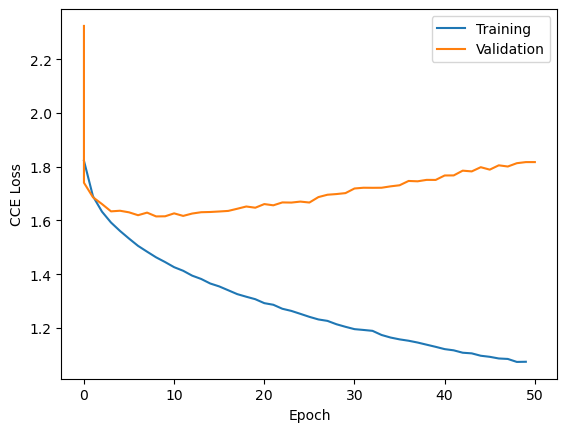

In [41]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

In [42]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.10050000 0.39620000 0.42129999 0.43099999 0.43259999 0.43540001 0.43840000 0.43520001 0.43840000 0.44040000 0.44299999 0.43599999 0.43939999 0.43820000 0.44170001 0.44080001 0.44240001 0.43869999 0.43740001 0.43779999 0.44470000 0.43660000 0.44139999 0.43470001 0.43770000 0.43759999 0.44069999 0.42969999 0.43149999 0.43180001 0.43270001 0.43329999 0.42760000 0.43730000 0.43090001 0.43439999 0.43500000 0.42730001 0.43130001 0.42930001 0.43149999 0.42850000 0.42809999 0.42620000 0.42469999 0.42210001 0.42670000 0.42919999 0.42699999 0.42800000 0.41880000 0.41880000


In [43]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.42480000853538513    │
│         test_loss         │    1.8170148134231567     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.42480000853538513
